# Ground truth spike shapes

author: steeve.laquitaine@epfl.ch  
date: 06.02.2024  
purpose: Plot typical examples of ground truth units' spike waveform profiles  
challenge: waveform aligment  

### Steps

1. Spike sorting (21 min): `notebooks/0_method/4_sorting/silico/0_marques/sorting.ipynb`

2. Waveform extraction (23 min): `notebooks/0_method/5_postpro/silico/0_marques/waveform.ipynb`

In [458]:
# import libs
%load_ext autoreload
%autoreload 2

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import os
import pandas as pd
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import spikeinterface as si
import spikeinterface.extractors as se
from scipy.optimize import minimize
import spikeinterface.full as si_full
import seaborn as sns
import spikeinterface.postprocessing as spost
from concurrent.futures import ProcessPoolExecutor


# move to PROJECT PATH
PROJ_PATH = "/gpfs/bbp.cscs.ch/project/proj85/home/laquitai/spikebias/"
os.chdir(PROJ_PATH)

from src.nodes.utils import get_config
from src.nodes.study import amplitude
from src.nodes.postpro import waveform

# SETUP PARAMETERS
MS_BEFORE = 3           # ms
MS_AFTER = 3            # ms

# silico
data_conf_sili, param_conf_sili = get_config("silico_neuropixels", "2023_10_18").values()
RAW_PATH_sili = data_conf_sili["recording"]["input"]
PREP_PATH_sili = data_conf_sili["preprocessing"]["output"]["trace_file_path"]
SNR_PATH_sili = data_conf_sili["postprocessing"]["trace_snr"]
STUDY_FOLDER_sili = data_conf_sili["postprocessing"]["waveform"]["ground_truth"]["study"]


# FIGURE SETTINGS
COLOR_VIVO = (0.7, 0.7, 0.7)
COLOR_SILI = (0.84, 0.27, 0.2)
COLOR_STIM = (0.6, 0.75, 0.1)
BOX_ASPECT = 1                  # square fig
FIG_SIZE = (4,4)
N_MAJOR_TICKS = 6
N_MINOR_TICKS = 12
plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.size"] = 24
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['axes.linewidth'] = 1
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['xtick.major.width'] = 1
plt.rcParams['xtick.minor.size'] = 3
plt.rcParams['xtick.major.size'] = 7
plt.rcParams['ytick.major.size'] = 7
plt.rcParams['ytick.major.width'] = 1
legend_cfg = {"frameon": False, "handletextpad": 0.1}
savefig_cfg = {"transparent":True}
# print(plt.rcParams.keys())

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
2024-02-06 12:28:56,172 - root - utils.py - get_config - INFO - Reading experiment config.
2024-02-06 12:28:56,205 - root - utils.py - get_config - INFO - Reading experiment config. - done


### Load waveforms

In [2]:
# takes 24 min
# load stuffs
Recording = si.load_extractor(PREP_PATH_sili)
WaveformExtractor = waveform.load(
    Recording,
    study_folder=STUDY_FOLDER_sili,
    ms_before=MS_BEFORE,
    ms_after=MS_AFTER,
)

# list sorted units
WaveformExtractor.unit_ids

### Explore spikes

Observations:

* Pauk et al., plotted spike periods of 0.55 ms (Human data)
    * 0.667 ms for 146.75 points width -> 110 points for 0.5 ms
* Sun et al., plotted spike periods of 2.5 ms (Cat data)
* Our spikes durations are longer than the cat's and much longer than Humans, up to 6 ms.
    * On our figure: 106.5 points width for 6 ms duration -> 0.5 ms legend bar = 8.875 points width


In [459]:
# takes 0.8 secs


def get_unit_largest_templates_parallelized(array, cell_id):
    N_SPIKES = 1

    # get waveforms
    wfs = WaveformExtractor.get_waveforms(cell_id)

    # get this unit's templates per site
    site_templates = []
    peak_to_peak_amps = []
    for site in range(384):
        template = np.median(wfs[:, :, site].T, axis=1)
        peak_to_peak_amps.append(max(template) - min(template))
        site_templates.append(template)
    site_templates = np.array(site_templates).T

    # get six largest median spikes (templates) and concatenate as a single row instance for UMAP
    descend_sort_ix = np.argsort(peak_to_peak_amps)[::-1]
    unit_i_spike = site_templates[:, descend_sort_ix[:N_SPIKES]].T.flatten()
    return unit_i_spike

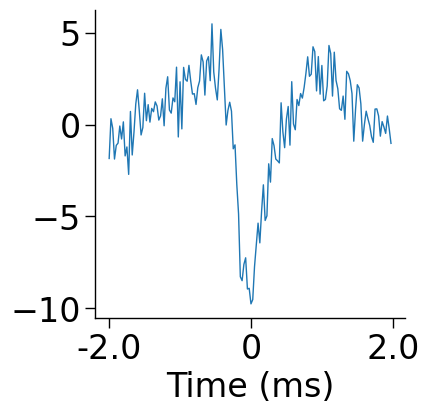

In [460]:
# red/blue ("RS: wide waveform")
# - large: 40, 47, 56

# purple/green ("broad spikes"):
# - small: 15, 24, 44, 57,75
# - large: 70

# dark blue/orange ("Fast spiking", "narrow waveform"):
# - small: 16, 19, 21, 45, 46, 61, 66
# - large: 17, 20, 29, 31, 32, 33, 36, 37, 50, 71, 76, 79

# light blue/purple ("Triphasic"):
# - small: 65
# - large: 18, 34, 37, 38, 39,54

# yellow/black ("positive spike")
# - large: 62

# unsorted:
# - large: 27, 52, 67,
# - small: 68, 69

U_I = 0
adjust = 0

PAULK_PERIOD = 0.55
SUN_PERIOD = 4

# takes 24 min
# load stuffs
Recording = si.load_extractor(PREP_PATH_sili)
WaveformExtractor = waveform.load(
    Recording,
    study_folder=STUDY_FOLDER_sili,
    ms_before=MS_BEFORE,
    ms_after=MS_AFTER,
)

unit_ids = WaveformExtractor.unit_ids[U_I]

# compute unit's six largest templates
# (parallelized over units)
with ProcessPoolExecutor() as executor:
    site_templates = executor.map(
        get_unit_largest_templates_parallelized,
        np.arange(0, 1, 1),  # dummy not used
        [unit_ids],
    )
site_templates = list(site_templates)

# format for wavemap (templates x (6 sites x ntimepoints))
site_templates_all = site_templates[0].tolist()
templates_for_wavemap = np.array(site_templates_all)

# reduce period to discard colliding spikes from other units
# PERIOD_TO_DISCARD_NOISE = 50
# center = int(len(templates_for_wavemap) / 2)
# templates_for_wavemap = templates_for_wavemap[
#     center - PERIOD_TO_DISCARD_NOISE : center + PERIOD_TO_DISCARD_NOISE
# ]

# select same spike period as Paulk et al. (0.55 msecs)
time_step_ms = 1 / 40000 * 1000
paul_spike_period_timepts = SUN_PERIOD / time_step_ms
MS_BEFORE = int(np.round(paul_spike_period_timepts / 2))
MS_AFTER = int(np.round(paul_spike_period_timepts / 2))

# find negative peak
neg_peak_timepts = np.argmin(templates_for_wavemap)

# center on negative peak
spike_start = neg_peak_timepts - MS_BEFORE
spike_end = neg_peak_timepts + MS_AFTER

# plot Sun's period (2.5 msecs)
fig, axis = plt.subplots(1, 1, figsize=(4, 4))
axis.plot(templates_for_wavemap[spike_start + adjust : spike_end + adjust])
axis.set_xticks([0, MS_BEFORE, MS_BEFORE + MS_AFTER])
axis.set_xticklabels([-MS_BEFORE * time_step_ms, 0, MS_AFTER * time_step_ms])
axis.set_xlabel("Time (ms)")
plt.show()

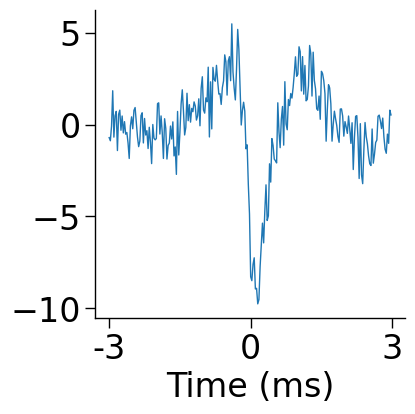

In [476]:
# 6 msecs periods
fig, axis = plt.subplots(1, 1, figsize=(4, 4))
axis.plot(templates_for_wavemap)
axis.set_xticks([0, 3 / time_step_ms, 6 / time_step_ms])
axis.set_xticklabels([-3, 0, 3])
axis.set_xlabel("Time (ms)")
plt.show()

### Profile 1

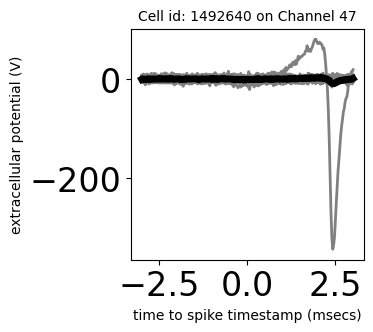

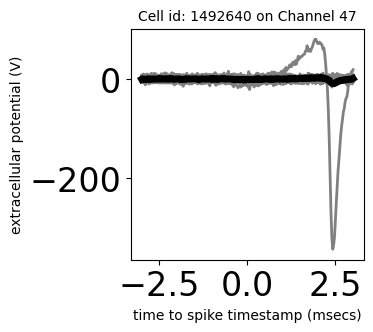

In [4]:
# takes 1.5 min
fig = waveform.plot(
    WaveformExtractor=WaveformExtractor,
    cell_id=1492640,
    colors=[(0.5, 0.5, 0.5), (0, 0, 0)],
    linewidth_instance=2,
    linewidth_mean=5,
)
fig
# plt.savefig("figures/2_realism/3_spikes/1_shape/npx384_sim_hex01/spike_shape_1.pdf")

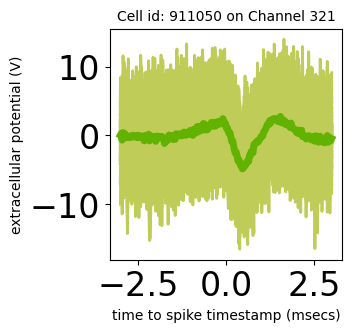

In [9]:
fig = waveform.plot(
    WaveformExtractor=WaveformExtractor,
    cell_id=911050,
    colors=[(0.75, 0.8, 0.34), (0.38, 0.70, 0)],
    linewidth_instance=2,
    linewidth_mean=5,
)
fig
# plt.savefig("figures/2_realism/3_spikes/1_shape/npx384_sim_hex01/spike_shape_2.pdf")

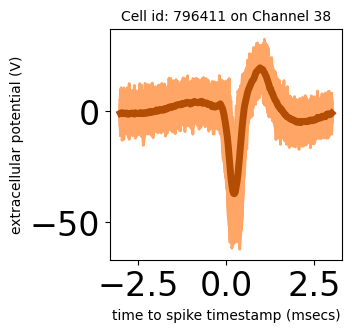

In [8]:
# takes 1.5 min
fig = waveform.plot(
    WaveformExtractor=WaveformExtractor,
    cell_id=796411,
    colors=[(0.85, 0.59, 0.8), (0.62, 0.18, 0.8)],  # purple
    linewidth_instance=2,
    linewidth_mean=5,
)
fig
# plt.savefig("figures/2_realism/3_spikes/1_shape/npx384_sim_hex01/spike_shape_1.pdf")

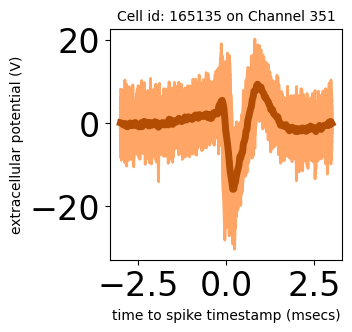

In [11]:
fig = waveform.plot(
    WaveformExtractor=WaveformExtractor,
    cell_id=165135,
    colors=[(1, 0.65, 0.4), (0.7, 0.3, 0.01)],
    linewidth_instance=2,
    linewidth_mean=5,
)
fig
# plt.savefig("figures/2_realism/3_spikes/1_shape/npx384_sim_hex01/spike_shape_4.pdf")

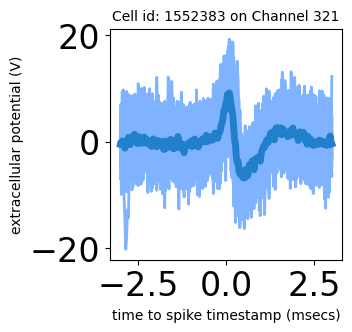

In [7]:
fig = waveform.plot(
    WaveformExtractor=WaveformExtractor,
    cell_id=1552383,
    colors=[(0.5, 0.7, 1), (0.13, 0.5, 0.8)],
    linewidth_instance=2,
    linewidth_mean=5,
)
fig
# plt.savefig("figures/2_realism/3_spikes/1_shape/npx384_sim_hex01/spike_shape_5.pdf")

In [ ]:
fig = waveform.plot(
    WaveformExtractor=WaveformExtractor,
    cell_id=796411,
    colors=[(0.85, 0.59, 0.8), (0.62, 0.18, 0.8)],
    linewidth_instance=2,
    linewidth_mean=5,
)
fig